# Cellar Track LSTM Text Classification


In [116]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Conv1D, Dense, MaxPooling1D, GlobalMaxPooling1D, Embedding, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split

%matplotlib inline

## Data Prep

We'll read the Cellar Tracker data directly from Data.World.  This will take a bit to download.  Once it's downloaded, we can do some basic analysis on the dataset to see what we're dealing with.

In [2]:
df = pd.read_csv('https://query.data.world/s/r8VVStpwMgTZlScD_VyeGd6JUEX4fm')

Reviews with review/points assigned = 773497


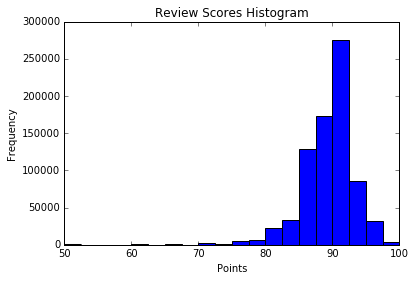

In [3]:
# Don't use rows where review/points or review/text is not provided
scored_df = df[df['review/points'].notnull()]
scored_df = scored_df[scored_df['review/text'].notnull()]

print('Reviews with review/points assigned = {}'.format(len(scored_df)))

plt.hist(scored_df['review/points'].values, bins = 20)
plt.title("Review Scores Histogram")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.show()

In [86]:
sized = scored_df.groupby('review/points').size()

In [89]:
count_dict = sized.to_dict()

In [82]:
sized_df = sized.to_frame()
#sized_df['review/points-pct'] = sized_df['review/points'].map(lambda s: s / sized.sum())

In [62]:
counts

array([   378,     26,     19,     11,     11,     80,     10,      7,
           24,     21,    417,     23,     32,     24,     35,    388,
           33,     72,    163,    216,   1664,    199,    582,    371,
         1052,   2952,    980,   1330,   2983,   4116,   8261,   3812,
        10152,  11268,  22172,  32703,  39115,  57345,  86477,  86012,
       109583,  84609,  81446,  53581,  32323,  18958,   8890,   4404,
         2446,   1004,    717])

In [106]:
target = 77000
accrued = 0

bucket = 1
buckets = { bucket: [] }

for points in range(50, 101):     
        buckets[bucket].append(points)
        accrued += count_dict[points]
    
        if accrued >= target:        
            bucket += 1
            buckets[bucket] = []
            remaining = target

d

In [110]:
def assign_grade(review_points):
    if review_points == 100:
        return "AAA"
    elif review_points == 99:
        return "AA"
    elif review_points == 98:
        return "A"
    elif review_points == 97:
        return "BBB"
    elif review_points == 96:
        return "BB"
    elif review_points == 95:
        return "B"
    elif review_points == 94:
        return "CCC"
    elif review_points == 93:
        return "CC"
    elif review_points == 92:
        return "C"
    elif review_points == 91:
        return "DDD"    
    elif review_points == 90:
        return "DD"
    elif review_points == 89:
        return "D"
    elif review_points == 88:
        return "FFF"
    elif review_points == 87:
        return "FF"
    elif review_points == 86:
        return "F"
    else:
        return "ZZZ"    

In [114]:
scored_df['Grade'] = scored_df['review/points'].map(assign_grade)

In [115]:
scored_df

,chunk_id,review/points,review/text,review/time,review/userId,review/userName,wine/name,wine/variant,wine/wineId,wine/year,Grade
0,1,96.0,"Olive, horse sweat, dirty saddle, and smoke. T...",1160179200,1,Eric,1981 Ch&#226;teau de Beaucastel Ch&#226;teaune...,Red Rhone Blend,18856,1981.0,BB
1,2,93.0,A remarkably floral nose with violet and chamb...,1063929600,1,Eric,1995 Ch&#226;teau Pichon-Longueville Baron,Red Bordeaux Blend,3495,1995.0,CC
2,3,92.0,"Fantastic wine! Blackberry, smoke, olive, stem...",1195948800,1,Eric,2001 Thierry Allemand Cornas Reynard,Syrah,40451,2001.0,C
5,6,96.0,"Much more yeasty, very Krug-like (guessed blin...",1134172800,1,Eric,1990 Krug Champagne Brut,Champagne Blend,16892,1990.0,BB
6,7,92.0,This shows a very ripe nose with chalky notes....,1082851200,1,Eric,2002 Weingut Hirsch Gr&#252;ner Veltliner Kammern,Gr&#252;ner Veltliner,17478,2002.0,C
7,8,95.0,"Nice showing. Decanted for 2 hours. Smoke, ber...",1246060800,1,Eric,1999 Quilceda Creek Cabernet Sauvignon,Cabernet Sauvignon,372,1999.0,B
10,11,94.0,Dinner with Mom and Bob at Lampreia. I was stu...,1080345600,1,Eric,1982 Ch&#226;teau L&#233;oville Poyferr&#233;,Red Bordeaux Blend,255,1982.0,CCC
11,12,86.0,"A nice nose, much like the 1985, stalk and tob...",1172188800,1,Eric,1988 Ch&#226;teau Pichon Longueville Comtesse ...,Red Bordeaux Blend,17796,1988.0,F
12,13,91.0,"Mmm, this is still pretty tight but quite a ni...",1233014400,1,Eric,2001 Les Cailloux (Lucien et Andr&#233; Brunel...,Red Rhone Blend,5851,2001.0,DDD
13,14,91.0,Dinner with Amy & Justin at Val d'Isere. $160 ...,1071964800,1,Eric,1999 DeLille Cellars Chaleur Estate,Red Bordeaux Blend,137,1999.0,DDD


In [118]:
X = scored_df['review/text'].values
y = scored_df['Grade'].values



In [119]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print ('There are {} words across all reviews'.format(len(word_index)))

There are 152285 words across all reviews


In [ ]:
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 50

(x_train, x_test, y_train, y_test) = train_test_split(X, y, test_size = .20)

data = pad_sequences(x_train, maxlen= MAX_SEQUENCE_LENGTH)
labels = np_util.to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', target.shape)